In [7]:
# import required packages
import geopandas as gpd
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
!pip install mapclassify
import matplotlib.pyplot as plt
# import the required machine learning packages
from sklearn import cluster
from sklearn.preprocessing import scale

# set seaborn plotting theme to white
sns.set_theme(style="white")

In [8]:
# Read in the LSOA shp file for Leeds
leeds_shp =gpd.read_file('Leeds.geojson')
leeds_shp.head()

,FID,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,10720,E01011264,Leeds 011A,420937,441836,-1.68306,53.87232,14a73329-fc8f-464c-a4fa-1963baa35500,"POLYGON ((421248.688 442315.812, 421284.073 44..."
1,10721,E01011265,Leeds 009A,418988,441951,-1.71269,53.87343,eda471dd-f408-4dab-917e-c5e188310b35,"POLYGON ((418635.000 442559.000, 418637.555 44..."
2,10722,E01011266,Leeds 008A,417489,442615,-1.73545,53.87945,286c32c5-ef49-4ecc-a45e-57630c165c62,"POLYGON ((417783.688 443382.312, 417788.688 44..."
3,10723,E01011267,Leeds 009B,419641,442025,-1.70276,53.87407,318cfaa3-9f08-4d61-a30e-82e903f3a7ba,"POLYGON ((419607.843 442388.568, 419612.752 44..."
4,10724,E01011268,Leeds 010A,420224,441935,-1.69390,53.87324,049e79f0-cd9e-47dc-848b-b6d6fa6825ac,"POLYGON ((420442.406 442436.687, 420443.313 44..."


In [9]:
# # Data downloaded from https://geoportal.statistics.gov.uk/maps/761ecd09b4124843b95511a242e2b1a1
# Because the data is too large to upload in Minerva and GitHub, put links to
# the websites where the data was found here.
shp = gpd.read_file('Lower_layer_Super_Output_Areas_2021_EW_BFE_V9_-3647710721716634062.geojson')
leeds_shp =shp.loc[shp['LSOA21NM'].str.contains('Leeds'),:]
leeds_shp.to_file('Leeds.geojson')

In [10]:
# Data-preprocessing
# Import data
# Read in csv data using pandas
age = pd.read_csv('age.csv')
crime = pd.read_csv('crime_10_2021.csv')
work = pd.read_csv('work.csv')
economics = pd.read_csv('economics.csv')

# Look at the colums in the data
age.columns
crime.columns
work.columns
economics.columns

# Check for missing data
age.isnull().sum()
crime.isnull().sum()
work.isnull().sum()
economics.isnull().sum()

date                                                                            0
geography                                                                       0
geography code                                                                  0
Economic activity status: Total: All usual residents aged 16 years and over     0
Economic activity status: Economically active (excluding full-time students)    0
Economic activity status: Economically active and a full-time student           0
Number of economically active persons                                           0
percentage of economically active persons                                       0
dtype: int64

In [11]:
# Calculate the total number of offences in each area of Leeds. And write the
# results into a new data frame to facilitate subsequent analysis of the number
# of crimes in each area of Leeds.
grouped_crime = crime.groupby('LSOA code')['number of offences'].sum().reset_index()
print(grouped_crime)
crime_region = pd.DataFrame(grouped_crime)

# Link the four datasets together.
age_crime  = pd.merge(age, crime_region,  left_on='LSOA 2021 Code', right_on='LSOA code', how='left')
age_crime_work = pd.merge(age_crime, work, left_on='LSOA code', right_on='geography code', how='left')
age_crime_work_economics = pd.merge(age_crime_work, economics, left_on='LSOA code', right_on='geography code', how='left')
age_crime_work_economics.head()

# Check for missing data
age_crime_work_economics.isnull().sum()

# join the age_crime_work_economics data to the leeds_shp geodataframe using a
# lefthand join
leeds_s =leeds_shp.merge(age_crime_work_economics, how='left',left_on='LSOA21CD',right_on='LSOA code')
leeds_s.columns

     LSOA code  number of offences
0    E01011264                   6
1    E01011265                  20
2    E01011266                   6
3    E01011267                  20
4    E01011268                  11
..         ...                 ...
473  E01033031                  41
474  E01033032                  28
475  E01033033                   8
476  E01033034                  18
477  E01033035                  38

[478 rows x 2 columns]


Index(['FID', 'LSOA21CD', 'LSOA21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'geometry', 'LAD 2021 Code', 'LAD 2021 Name',
       'LSOA 2021 Code', 'LSOA 2021 Name', 'Total_x', 'F0 to 15', 'F16 to 29',
       'F30 to 44', 'F45 to 64', 'F65 and over', 'M0 to 15', 'M16 to 29',
       'M30 to 44', 'M45 to 64', 'M65 and over', 'youngs',
       'proportion of youth population', 'LSOA code', 'number of offences',
       'date_x', 'geography_x', 'geography code_x',
       'Number of people not in work', 'Total_y',
       'percentage of persons not working', 'date_y', 'geography_y',
       'geography code_y',
       'Economic activity status: Total: All usual residents aged 16 years and over',
       'Economic activity status: Economically active (excluding full-time students)',
       'Economic activity status: Economically active and a full-time student',
       'Number of economically active persons',
       'percentage of economically active persons'],
      dtype='object')

In [12]:
# Calculate Spearman's rank correlation
leeds_s_corr =leeds_s[['proportion of youth population','number of offences','percentage of persons not working','percentage of economically active persons']].corr(method = 'spearman')
leeds_s_corr

,proportion of youth population,number of offences,percentage of persons not working,percentage of economically active persons
proportion of youth population,1.000000,0.509949,0.006384,0.012754
number of offences,0.509949,1.000000,0.089777,-0.064653
percentage of persons not working,0.006384,0.089777,1.000000,-0.919714
percentage of economically active persons,0.012754,-0.064653,-0.919714,1.000000


Labels: Index(['proportion of youth population', 'number of offences',
       'percentage of persons not working',
       'percentage of economically active persons'],
      dtype='object') Index(['proportion of youth population', 'number of offences',
       'percentage of persons not working',
       'percentage of economically active persons'],
      dtype='object')
Labels with capital letters: ['Proportion of youth population', 'Number of offences', 'Percentage of persons not working', 'Percentage of economically active persons'] ['Proportion of youth population', 'Number of offences', 'Percentage of persons not working', 'Percentage of economically active persons']


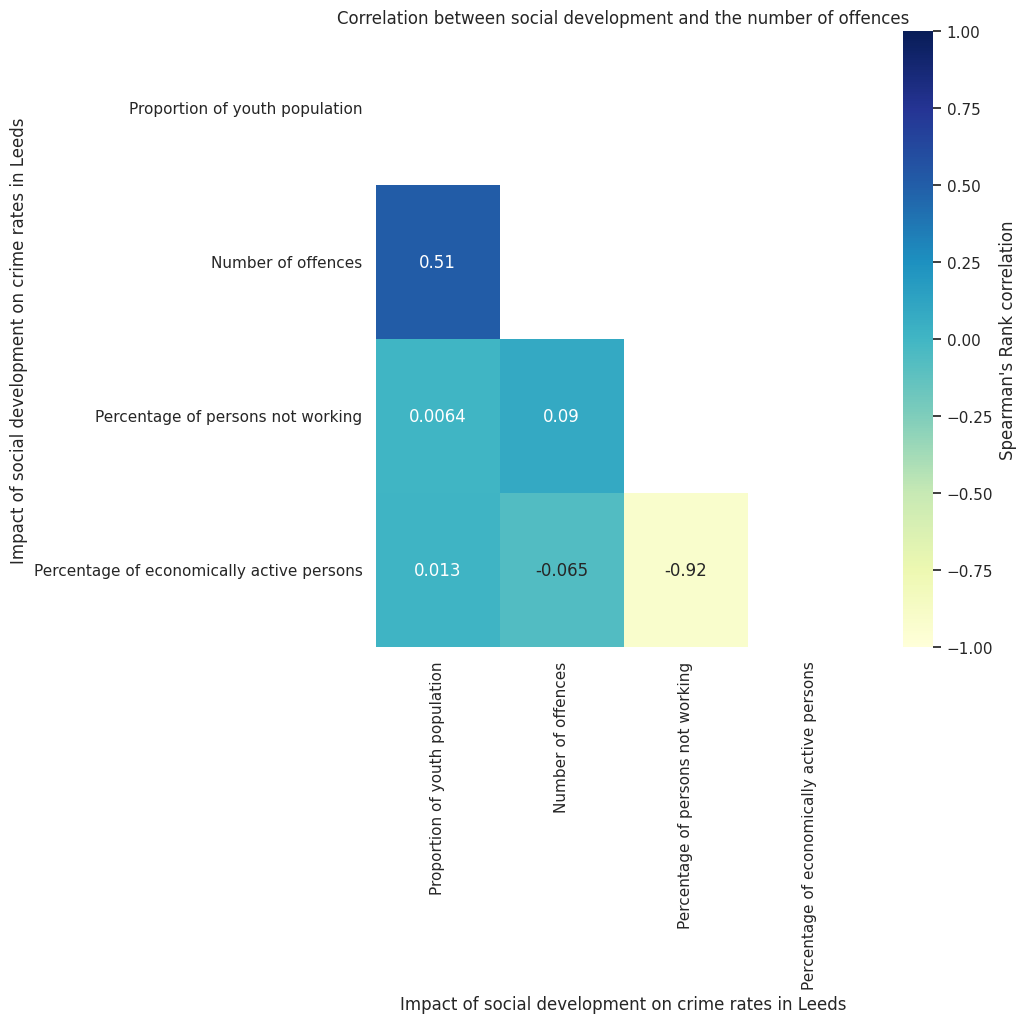

In [13]:
# Showing Spearman rank correlation between factors
# define plot size
fig,ax = plt.subplots(figsize=(8,8))

# define mask to apply to upper right hand corner of the plot
data_to_mask = np.triu(np.ones_like(leeds_s_corr))

# define axis tick labels
# get the index and the columns, replace the underscores with spaces
x_axis_labels = leeds_s_corr.columns.str.replace('_',' ')
y_axis_labels = leeds_s_corr.index.str.replace('_',' ')

# Have a look at what the tick labels look like
print('Labels:',x_axis_labels ,y_axis_labels)

# Uppercase each element of the x_axis_labels list
x_axis_labels = [element.capitalize() for element in x_axis_labels]
y_axis_labels = [element.capitalize() for element in y_axis_labels]

# look at the new labels
print('Labels with capital letters:',x_axis_labels ,y_axis_labels)


# plot a heatmap of the correlation dataframe
sns.heatmap(leeds_s_corr,
            # annotate so spearman's rank correlation values are displayed on the squares
            annot=True,
            # define colourmap
            cmap='YlGnBu',
            # define value of minimum colour on cbar
            vmin=-1,
            # define value of maximum colour on cbar
            vmax=1,
            # add the mask
            mask=data_to_mask,
            # use the custom tick labels
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            # add a label to the cbar
            cbar_kws={'label': "Spearman's Rank correlation"},
            # plot on the axis we defined
            ax=ax)

# Set axis labels
ax.set(xlabel="Impact of social development on crime rates in Leeds",
       ylabel="Impact of social development on crime rates in Leeds",
      title ='Correlation between social development and the number of offences' );
plt.savefig('Correlation_between_social_development_and_the_number_of_offences.png')


# The topic of this assignment investigation is the relationship between social
# development and crime rates in Leeds. In order to promote better development
# of the city, it is necessary to reduce the crime rate. (Atkinson and Helms,
# 2007) Therefore, for this assignment the number of young people, the number of
# economically active people, the number of people not in work and the number of
# crimes in Leeds in October 2021 were selected from the 2021 census data to
# investigate the relationship between social development and crime rates.

# The graph below shows the correlation between aspects of social development
# and the number of offences. As can be seen from the graph, the highest
# correlation between the percentage of young people and the number of crimes is
# 0.51. Most young people are impulsive, immature and relatively susceptible to
# a variety of influences that can greatly contribute to or hinder
# socio-economic development. Therefore, areas with a higher percentage of young
# people should be given more attention. (Sandoval Garrido, 2021) There is a
# negative correlation between the number of crimes and the percentage of
# economically active people in the region, which means that the more
# economically active people in the region, the smaller the number of crimes are
# likely to be. The correlation between the number of people without a job in
# the region and the number of crimes is positive at 0.09, which means that the
# more people without a job in the region the greater the number of crimes that
# may occur.

# From the figure below, it appears that the proportion of young people in the
# region has the greatest impact on the number of crimes committed in the
# region. It has also been shown that the proportion of young people in the
# number of crimes committed has also increased significantly in recent years.
# (Aebi and Linde, 2010) In order to reduce the number of crimes in the region,
# it is possible to consider working with young people, for example by
# increasing the employment rate of young people as well as increasing school
# and community interventions. (Ivaschenko et al, 2017; Masho et al, 2019)
# Socio-economic conditions, such as the number of economically active people
# and the number of people who are not in work, although they have some impact
# on the number of cases in the area, they are also affected by the development
# of other social factors, so there is a need to include other aspects of the
# indicators to be evaluated in future research. (Remeikienė et al, 2022)

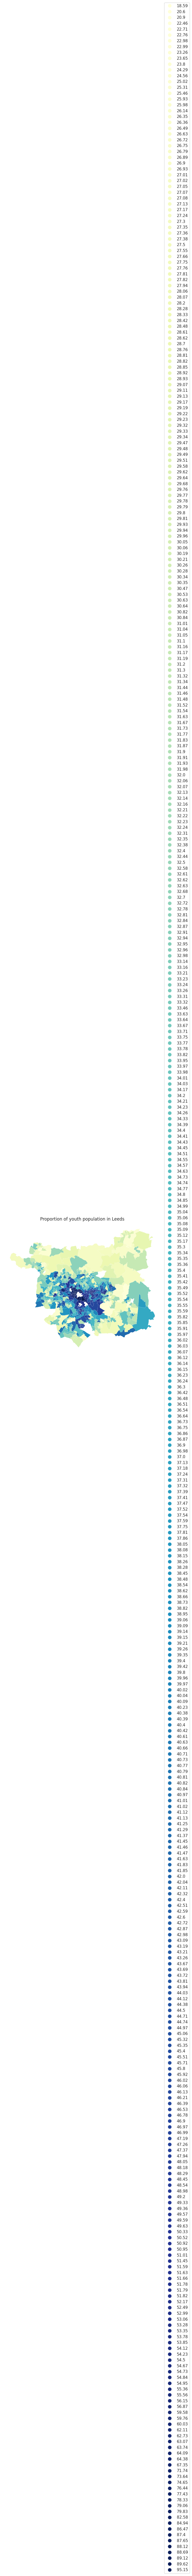

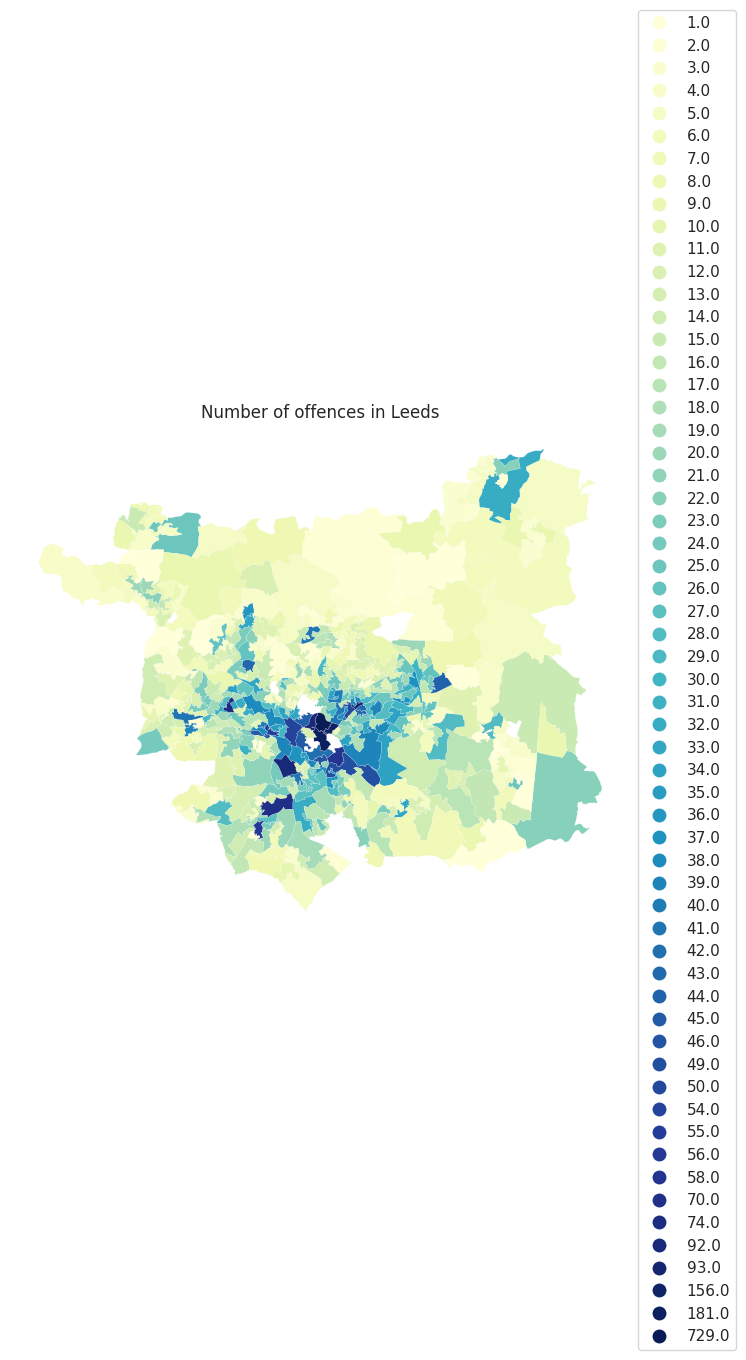

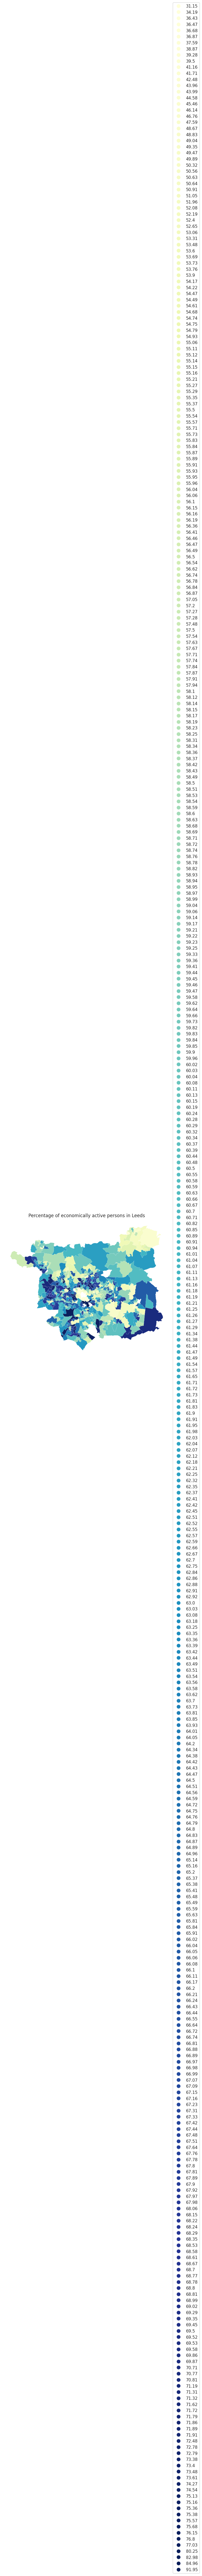

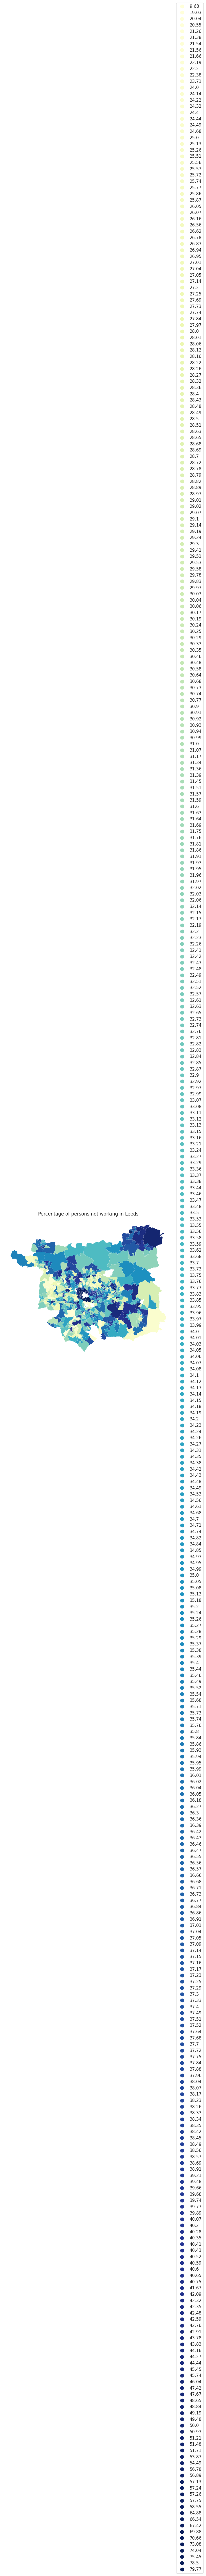

In [14]:
# create a list of the columns we want to plot
leeds_s_cols =['proportion of youth population','number of offences','percentage of economically active persons','percentage of persons not working']

# create a for loop for plotting a map of each domain

# for each item in a range from 0 to 3 (number of items in the leeds_s_cols list)
for i in range (0, len(leeds_s_cols)):

    # produce a plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # get the ith item in the leeds_s column list and plot
    leeds_s.plot(column=leeds_s_cols[i],


    #### format the plot ###

    # reduce linewidth between polygons
    linewidth =0.1,
    # specify data is categorical (ordinal)
    categorical=True,
    # show the legend
    legend=True,
    # define the legend palette
    cmap='YlGnBu',
    # use the define axis
    ax=ax,
    # position the legend
    legend_kwds={'loc': 'center left','bbox_to_anchor':(1,0.5)})

    # add a title based on the column plotted, formatting the title to look better
    plt.title(leeds_s_cols[i].replace('_',' ').capitalize()+' in Leeds')

    # do not plot with the axis showing
    plt.axis('off')

    # save the figure as an image with name reflecting the domain plotted
    plt.savefig(str(leeds_s_cols[i])+'_'+'Leeds'+'.jpg',bbox_inches='tight');


# The purpose of this assignment is to examine the relationship between social
# development and crime rates, the following four graphs represent the
# proportion of the youth population in Leeds, the percentage of the
# economically active population in Leeds, the percentage of the non-working
# population in Leeds and the number of offences in Leeds. The same colour
# labels have been chosen for all four graphs and the values have been arranged
# in order from smallest to largest so that the spatial variation of the values
# can be seen at a glance. The colour scheme from light yellow to dark blue has
# also been chosen because the brightness of the colours in this colour scheme
# varies, making the four charts easier to interpret.

# There are studies that show that the proportion of the youth population is an
# important factor in local crime rates. (Mulamba, 2021) Therefore, the youth
# population proportion was chosen as one of the subjects of the study. A map of
# the spatial distribution of youth population proportions in Leeds shows that
# Leeds city centre has the highest youth population proportions. Areas of Leeds
# with low youth population proportions are concentrated in the north of the
# city, with higher youth population proportions in Leeds city centre and the
# west. However, there are some outliers, for example, four areas in Leeds City
# Centre have a youth population proportion below 20% and one area in South
# Leeds has a youth population proportion as high as 50% to 60%.

# The Leeds crime numbers graph shows that Leeds City Centre has a high number
# of crimes and North Leeds has a low number of crimes. The area with the
# highest number of crimes is Leeds City Centre with over 700 cases. There are
# eight areas with low crime numbers. The majority of areas in Leeds had less
# than 100 offences, with a few areas having more than 200. The spatial
# distribution is broadly similar to the proportion of the youth population in
# Leeds.

# A reduction in the number of economically active people may lead to an
# increase in crime. (Machin and Meghir, 2004) Therefore the percentage of
# economically active people was chosen as one of the objects of study. A graph
# of the percentage of economically active people in Leeds shows that the areas
# with a high number of economically active people are concentrated in the west
# of the city, with the north-east of the city having a lower number of
# economically active people. The highest value for the percentage of
# economically active people in each area of Leeds is 91.95 % and the lowest
# value for the percentage of economically active people is 31.15 %. Comparing
# the spatial distribution of the percentage of economically active people to
# the spatial distribution of crime rates, the opposite is largely true for all
# areas except the south-east of the city.

# There are studies that show that people without jobs are more likely to commit
# crimes. (Crutchfield, 2014) Therefore the percentage of the number of people
# not working was also chosen as one of the subjects of the study. As can be
# seen from the graph of the percentage of people in Leeds not working, the area
# with the highest percentage of people not working is the city centre, with
# over 55% of the population, and the lower percentage is concentrated in the
# western and south-eastern corners of the city, with less than 25% of the
# population. The spatial distribution of the percentage of people without work
# is the opposite of the spatial distribution of the percentage of economically
# active people and approximately the same as the spatial distribution of crime
# rates.

In [15]:
# Reference:
# Aebi, M.F. and Linde, A. 2010. Is There a Crime Drop in Western Europe? European journal on criminal policy and research. 16(4), pp.251–277.
# Atkinson, R. and Helms, G. 2007. Securing an urban renaissance : crime, community, and British urban policy In: Brisol, U.K: Policy Press.
# Crutchfield, R.D. 2014. Get a job labor markets, economic opportunity, and crime. New York: New York University Press.
# Ivaschenko, O., Naidoo, D., Newhouse, D. and Sultan, S. 2017. Can public works programs reduce youth crime? Evidence from Papua New Guinea’s Urban Youth Employment Project. IZA journal of development and migration. 7(9), pp.1–32.
# Machin, S. and Meghir, C. 2004. Crime and Economic Incentives. The Journal of human resources. 39(4), pp.958–979.
# Masho, S.W., Zirkle, K.W., Wheeler, D.C., Sullivan, T. and Farrell, A.D. 2019. Spatial Analysis of the Impact of a School-Level Youth Violence Prevention Program on Violent Crime Incidents in the Community. Prevention science. 20(4), pp.521–531.
# Mulamba, K.C. 2021. A Spatial Analysis of Property Crime Rates in South Africa. The South African Journal of economics. 89(3), pp.329–347.
# Remeikienė, R., Ligita, G., Fedajev, A., Raistenskis, E. and Krivins, A. 2022. Links between crime and economic development: EU classification. Equilibrium (Toruń ). 17(4), pp.909–938.